**DS3000 Final Project** 

Importing the data and checking the initial values

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# Model Construction
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold


# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

file = "/Users/aidanbugler/Desktop/3000 Final Project/Big_Black_Money_Dataset.csv"
data = pd.read_csv(file)

data.head()

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000000001,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,TX0000000002,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,TX0000000003,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,TX0000000004,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,TX0000000005,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


Checking the Corlation between all features 

Logistic Regression : 

classification_report : 
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      1403
           1       0.30      1.00      0.46       597

    accuracy                           0.30      2000
   macro avg       0.65      0.50      0.23      2000
weighted avg       0.79      0.30      0.14      2000

Accuracy : 0.3
Recall : 1.0
Precision : 0.29894842263395094
F1 score : 0.4602929838087895
AUC : 0.5010691375623664



/Users/aidanbugler/anaconda3/envs/DS3000/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/aidanbugler/anaconda3/envs/DS3000/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


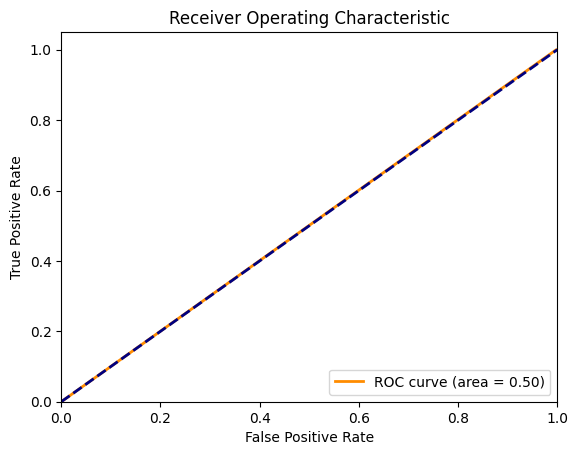

In [9]:
#first changing the catagorical columns to numaric using label encoding
encoded_data = data.copy()

## Convert the financial instituition information into numeric values
encoded_data['Financial Institution'] = encoded_data['Financial Institution'].str.replace('Bank_', '', regex = False).astype('int')

# Extracting features from the date
# Ensure the column is in datetime format
encoded_data['Date of Transaction'] = pd.to_datetime(encoded_data['Date of Transaction'], errors='coerce')

# Extracting features from the date
encoded_data['Year'] = encoded_data['Date of Transaction'].dt.year
encoded_data['Month'] = encoded_data['Date of Transaction'].dt.month
encoded_data['Day'] = encoded_data['Date of Transaction'].dt.day
encoded_data['DayOfWeek'] = encoded_data['Date of Transaction'].dt.dayofweek
encoded_data['Hour'] = encoded_data['Date of Transaction'].dt.hour
encoded_data.drop(['Date of Transaction'], axis = 1, inplace = True)

# Binning the transaction amount
encoded_data['Amount Category'] = pd.cut(encoded_data['Amount (USD)'], bins=[0, 10000, 50000, 100000, 500000, float('inf')],labels=['Low', 'Medium', 'High', 'Very High', 'Extreme'])

# Creating interaction terms
encoded_data['Amount_Risk_Interaction'] = encoded_data['Amount (USD)'] * encoded_data['Money Laundering Risk Score']
encoded_data.drop(columns = ['Amount (USD)', 'Money Laundering Risk Score'], axis = 1, inplace = True)

#Encoding Features
encoding_features = encoded_data.select_dtypes(include = ['object', 'bool', 'category'])

le = LabelEncoder()

for col in encoding_features.columns:
    encoded_data[col] = le.fit_transform(encoded_data[col])

copied_data = encoded_data.copy()

## Split X and y
X = copied_data.drop('Source of Money', axis = 1)
y = copied_data['Source of Money']

## Split the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 11, stratify = y)

## Initiate Upsampler and upsample the data
smote = SMOTE(random_state = 42)
X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train, y_train)

## Normalize features
scaler = MinMaxScaler()
X_train_upsampled = scaler.fit_transform(X_train_upsampled)
X_test = scaler.transform(X_test)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train_upsampled.shape, y_train_upsampled.shape

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('classification_report : \n', classification_report(y_test, y_pred))
    print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
    print(f'Recall : {recall_score(y_test, y_pred)}')
    print(f'Precision : {precision_score(y_test, y_pred)}')
    print(f'F1 score : {f1_score(y_test, y_pred)}')
    print(f'AUC : {roc_auc_score(y_test, y_pred)}')
    print('')
    
    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

print('Logistic Regression : \n')
log_clf = LogisticRegression(class_weight='balanced',random_state = 42)
evaluate_model(log_clf, X_train_upsampled, y_train_upsampled, X_test, y_test)

As we can see from this heat map there is no high correlation between features which means we should use logistic regression

Looking at the amount of money moving bewtween countries 

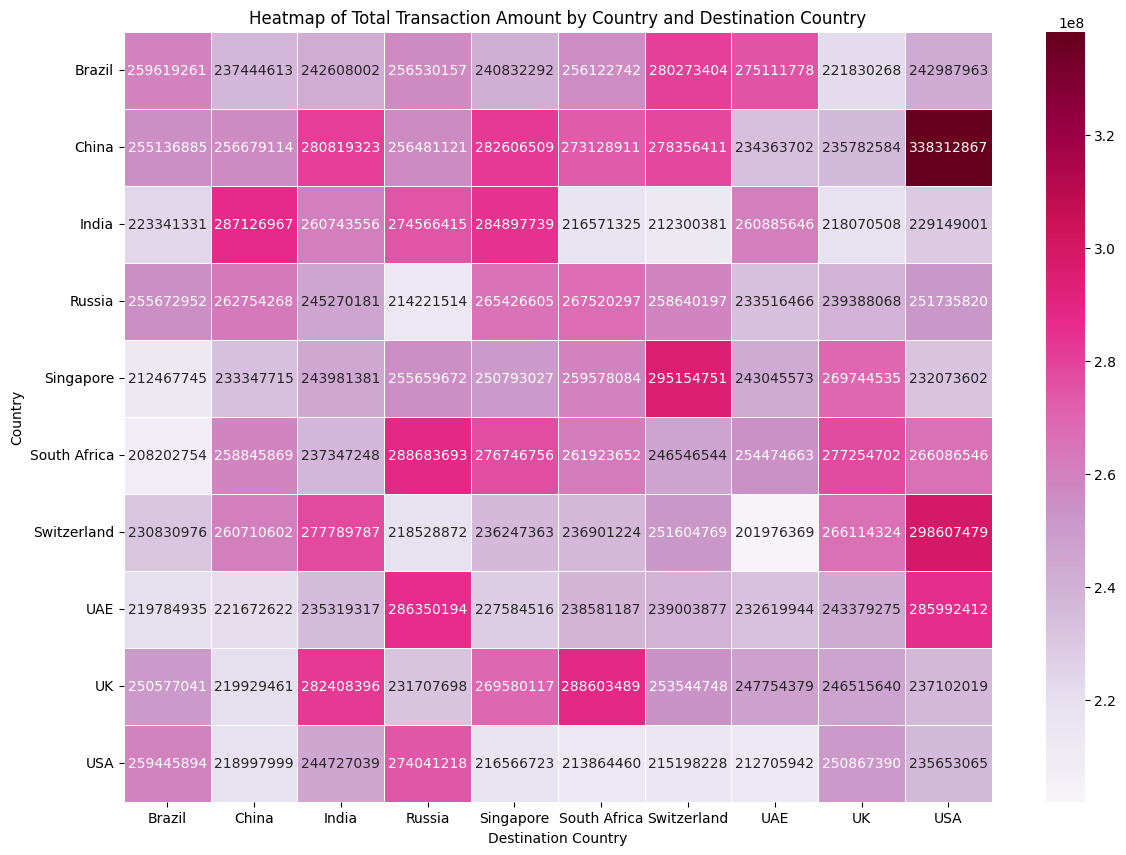

In [5]:
# Heatmap of total transaction amount by Country and Destination Country
pivot_table = data.pivot_table(values='Amount (USD)', index='Country', columns='Destination Country', aggfunc='sum', fill_value=0)
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap='PuRd', annot=True, fmt='.0f', linewidths=0.5)
plt.title('Heatmap of Total Transaction Amount by Country and Destination Country')
plt.xlabel('Destination Country')
plt.ylabel('Country')
plt.show()

From this heat map we can see that money coming from China and going to USA was the highest by far compared to the other countries

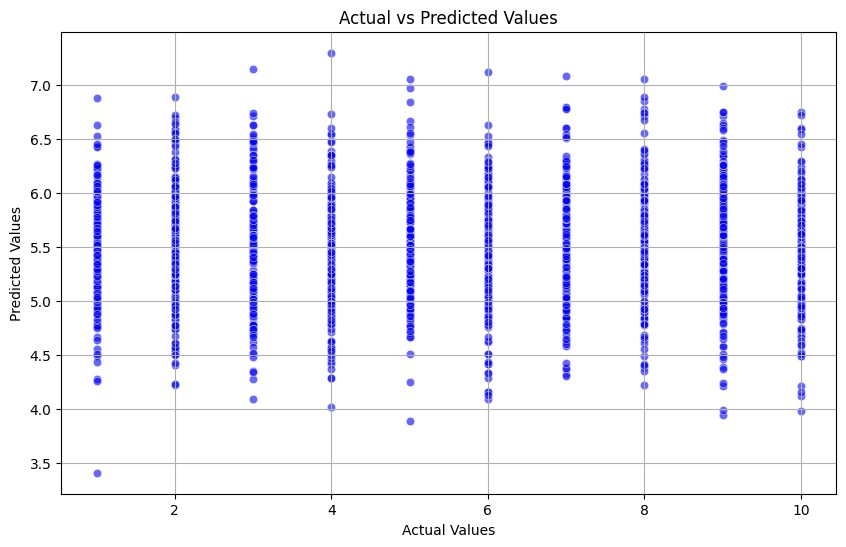

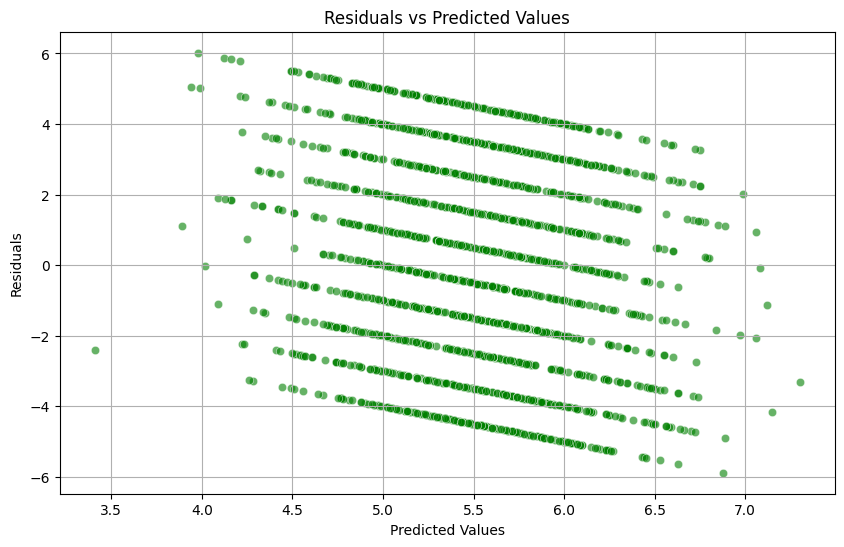

MSE: 8.55
R²: -0.04


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Features and target variable
X = data.drop(columns=['Money Laundering Risk Score'])
y = data['Money Laundering Risk Score']


# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

# Handle categorical features
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Handle numerical features (imputation)
imputer = SimpleImputer(strategy='mean')
X[numerical_features] = imputer.fit_transform(X[numerical_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.6)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

# Residual Plot: Actual vs Residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, color="green", alpha=0.6)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Step 1: Create classification target
# Binning Money Laundering Risk Score into categories
bins = [0, 3, 7, 10]  # Example bins for low, medium, high risk
labels = ['Low', 'Medium', 'High']
data['Risk_Category'] = pd.cut(data['Money Laundering Risk Score'], bins=bins, labels=labels)

# Encode target variable
data['Risk_Category'] = data['Risk_Category'].astype(str)
target = data['Risk_Category']

# Step 2: Preprocessing features
# Drop unnecessary columns
features = data.drop(columns=['Transaction ID', 'Date of Transaction', 'Money Laundering Risk Score', 'Risk_Category'])

# Encode categorical variables
features = pd.get_dummies(features, drop_first=True)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=0)

# Step 4: Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Correct max_features options
    'class_weight': ['balanced', None]  # Handling class imbalance
}

# Create Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Step 6: Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Step 7: Get the best hyperparameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Step 8: Evaluate the best model
y_pred_best = best_rf_model.predict(X_test)
y_pred_proba_best = best_rf_model.predict_proba(X_test)

# Step 9: Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

# AUC-ROC Score for binary classification (optional)
if len(labels) == 2:  # Binary classification
    auc_score_best = roc_auc_score(y_test, y_pred_proba_best[:, 1])
    print(f"AUC-ROC Score: {auc_score_best:.2f}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.6s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.5s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.9s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  10.3s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.1s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  25.5s
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt,

Trying a neural network

In [13]:
# Import necessary libraries for a neural network
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

# Step 0: Create classification target
# Binning Money Laundering Risk Score into categories
bins = [0, 3, 7, 10]  # Example bins for low, medium, high risk
labels = ['Low', 'Medium', 'High']
data['Risk_Category'] = pd.cut(data['Money Laundering Risk Score'], bins=bins, labels=labels)

# Encode target variable
data['Risk_Category'] = data['Risk_Category'].astype(str)
target = data['Risk_Category']

# Step 2: Preprocessing features
# Drop unnecessary columns
features = data.drop(columns=['Transaction ID', 'Date of Transaction', 'Money Laundering Risk Score', 'Risk_Category'])

# Encode categorical variables
features = pd.get_dummies(features, drop_first=True)

# Step 1: Preprocess the features (if not already done)
# Scale the features (important for neural networks)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: One-hot encode the target variable for multi-class classification
target_encoded = to_categorical(target.map({'Low': 0, 'Medium': 1, 'High': 2}))

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_encoded, test_size=0.5, random_state=42)

# Step 4: Build the Neural Network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer with 128 neurons
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
model.add(Dense(3, activation='softmax'))  # Output layer with 3 neurons (for 3 classes)

# Step 5: Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 6: Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Step 7: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Make predictions
y_pred = model.predict(X_test)

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Convert the predicted probabilities to class labels by taking the index of the highest probability
y_pred_labels = np.argmax(y_pred, axis=1)  # Get class labels (0, 1, or 2) for multi-class

# Convert y_test to class labels (reverse the one-hot encoding for evaluation)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, accuracy, and F1 score for multi-class classification
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')  # 'weighted' accounts for class imbalance
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Epoch 1/30


/Users/aidanbugler/anaconda3/envs/DS3000/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 - 1s - 9ms/step - accuracy: 0.3454 - loss: 1.2998 - val_accuracy: 0.3294 - val_loss: 1.1483
Epoch 2/30
157/157 - 1s - 4ms/step - accuracy: 0.4842 - loss: 1.0203 - val_accuracy: 0.3222 - val_loss: 1.1849
Epoch 3/30
157/157 - 1s - 4ms/step - accuracy: 0.6652 - loss: 0.7505 - val_accuracy: 0.3260 - val_loss: 1.3406
Epoch 4/30
157/157 - 1s - 5ms/step - accuracy: 0.7826 - loss: 0.5169 - val_accuracy: 0.3284 - val_loss: 1.6143
Epoch 5/30
157/157 - 1s - 7ms/step - accuracy: 0.8644 - loss: 0.3554 - val_accuracy: 0.3380 - val_loss: 1.8324
Epoch 6/30
157/157 - 1s - 9ms/step - accuracy: 0.8798 - loss: 0.2913 - val_accuracy: 0.3438 - val_loss: 2.0738
Epoch 7/30
157/157 - 1s - 9ms/step - accuracy: 0.9086 - loss: 0.2279 - val_accuracy: 0.3324 - val_loss: 2.2860
Epoch 8/30
157/157 - 1s - 7ms/step - accuracy: 0.9236 - loss: 0.1902 - val_accuracy: 0.3370 - val_loss: 2.5606
Epoch 9/30
157/157 - 1s - 7ms/step - accuracy: 0.9376 - loss: 0.1596 - val_accuracy: 0.3362 - val_loss: 2.7840
Epoch 10/30


Pivoting 